In [1]:
from collections import Counter

import matplotlib.pylab as plt
import numpy as np
import pandas as pd

import torch
from transformers import (
    VisionEncoderDecoderModel,
    default_data_collator,
    TrOCRProcessor,
)
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_metric

from sequence_mnist.model import SequenceMNIST
from tests.test_sequence_mnist import test_sample

/Users/maia/miniforge3/envs/huggingface/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_sample()

In [3]:
model = VisionEncoderDecoderModel.from_pretrained(
    "microsoft/trocr-small-printed", num_labels=10
)
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-printed")
train_dataset = SequenceMNIST(
    train=True, processor=processor, root="/tmp/data", download=True
)
test_dataset = SequenceMNIST(
    train=False, processor=processor, root="/tmp/data", download=True
)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Tokens for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# Vocab size is the number of integers 0-9
model.config.vocab_size = 10

In [5]:

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir="results/",
    logging_steps=2,
    save_steps=1000,
    num_train_epochs=2,
    eval_steps=200,
)

In [6]:
### HUGGING FACE

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


In [7]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=default_data_collator,
)

In [8]:
trainer.train()

/Users/maia/miniforge3/envs/huggingface/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 12000
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3000


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 2/3000 [00:46<19:10:38, 23.03s/it]

{'loss': 10.7245, 'learning_rate': 4.996666666666667e-05, 'epoch': 0.0}


  0%|          | 4/3000 [01:11<12:49:12, 15.40s/it]

{'loss': 6.8684, 'learning_rate': 4.993333333333334e-05, 'epoch': 0.0}


  0%|          | 6/3000 [01:27<9:15:31, 11.13s/it] 

{'loss': 5.9184, 'learning_rate': 4.99e-05, 'epoch': 0.0}


  0%|          | 8/3000 [01:42<7:42:26,  9.27s/it]

{'loss': 4.8369, 'learning_rate': 4.986666666666667e-05, 'epoch': 0.01}


  0%|          | 10/3000 [01:59<7:11:54,  8.67s/it]

{'loss': 3.9, 'learning_rate': 4.9833333333333336e-05, 'epoch': 0.01}


  0%|          | 12/3000 [02:14<6:42:02,  8.07s/it]

{'loss': 4.0747, 'learning_rate': 4.9800000000000004e-05, 'epoch': 0.01}


  0%|          | 14/3000 [02:29<6:27:20,  7.78s/it]

{'loss': 3.1409, 'learning_rate': 4.9766666666666666e-05, 'epoch': 0.01}


  1%|          | 16/3000 [02:44<6:21:25,  7.67s/it]

{'loss': 2.6323, 'learning_rate': 4.973333333333334e-05, 'epoch': 0.01}


  1%|          | 18/3000 [02:59<6:17:29,  7.60s/it]

{'loss': 2.4379, 'learning_rate': 4.97e-05, 'epoch': 0.01}


  1%|          | 20/3000 [03:14<6:11:19,  7.48s/it]

{'loss': 2.2449, 'learning_rate': 4.966666666666667e-05, 'epoch': 0.01}


  1%|          | 22/3000 [03:28<6:06:21,  7.38s/it]

{'loss': 2.1602, 'learning_rate': 4.963333333333334e-05, 'epoch': 0.01}


  1%|          | 23/3000 [03:36<6:10:09,  7.46s/it]

KeyboardInterrupt: 

In [13]:
def predict(model, pixel_values, **kwargs):
    generated_ids = model.generate(pixel_values.unsqueeze(dim=0))
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print(f'Prediction: {generated_text}, Sample: {kwargs}')
    return generated_text

In [14]:
# Predict a single instance
predict(model=model, **test_dataset[0])

Prediction: 548, Sample: {'labels': tensor([    0, 45578,  7127,     2,  -100]), 'text': '54025'}


'548'

In [43]:
torch.save(model.state_dict(), 'results/mnist_trained_trocr.pth')

Similarity metric isn't perfect as it doesn't account for order - but good enough proxy for quick eval.

In [194]:
def string_similarity(base_string: str, comp_string: str) -> float:
    base_dict = dict(Counter(base_string))
    for key in base_dict:
        comp_count = comp_string.count(key)
        gt_count = base_dict[key]
        base_dict[key] -= comp_count if comp_count <= gt_count else gt_count

    return 1 - sum(base_dict.values()) / (len(base_string) + 1e-9)

In [202]:
def eval_metrics(pred: str, gt: str) -> dict:

    correct = True if pred == gt else False
    similarity = (
        string_similarity(base_string=gt, comp_string=pred) if len(pred) > 0 else 0.0
    )

    return {"Correct": correct, "Similarity": similarity}

In [203]:
test_results = []
for sample in test_dataset:
    pred = predict(model=model, pixel_values=sample['pixel_values'])
    gt = sample['text']
    result = eval_metrics(pred, gt)
    result['Prediction'] = pred
    result['Ground Truth'] = gt
    test_results.append(result)
    #print(f'Label: {gt}, Prediction: {pred}, Result: {result}')

Label: 51133, Prediction: 51133, Result: {'Correct': True, 'Similarity': 1.0, 'Prediction': '51133', 'Ground Truth': '51133'}
Label: 21617, Prediction: , Result: {'Correct': False, 'Similarity': 0.0, 'Prediction': '', 'Ground Truth': '21617'}
Label: 34639, Prediction: , Result: {'Correct': False, 'Similarity': 0.0, 'Prediction': '', 'Ground Truth': '34639'}
Label: 23710, Prediction: , Result: {'Correct': False, 'Similarity': 0.0, 'Prediction': '', 'Ground Truth': '23710'}
Label: 00675, Prediction: 00675, Result: {'Correct': True, 'Similarity': 1.0, 'Prediction': '00675', 'Ground Truth': '00675'}
Label: 56967, Prediction: 5698, Result: {'Correct': False, 'Similarity': 0.60000000008, 'Prediction': '5698', 'Ground Truth': '56967'}
Label: 37310, Prediction: 3730, Result: {'Correct': False, 'Similarity': 0.80000000004, 'Prediction': '3730', 'Ground Truth': '37310'}
Label: 90828, Prediction: 70828, Result: {'Correct': False, 'Similarity': 0.80000000004, 'Prediction': '70828', 'Ground Truth':

Traceback (most recent call last):
  File "/Users/maia/miniforge3/envs/huggingface/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/0d/kmj6kw8523x6kfszxm3hmxgm0000gn/T/ipykernel_32570/4043038102.py", line 2, in <cell line: 2>
    for sample in test_dataset:
  File "/Users/maia/Documents/GitHub/professional/job_take_homes/starling/sequence-mnist/sequence_mnist/model/dataloader.py", line 59, in __getitem__
  File "<__array_function__ internals>", line 180, in hstack
  File "/Users/maia/miniforge3/envs/huggingface/lib/python3.9/site-packages/numpy/core/shape_base.py", line 345, in hstack
    return _nx.concatenate(arrs, 1)
  File "<__array_function__ internals>", line 180, in concatenate
ValueError: need at least one array to concatenate

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/maia/miniforge3/envs/hu

In [208]:
test_results_df = pd.DataFrame(test_results)

# Data Analysis

In [224]:
train_counter = Counter()
for sample in train_dataset:
    train_counter.update(sample['text'])


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/maia/miniforge3/envs/huggingface/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/0d/kmj6kw8523x6kfszxm3hmxgm0000gn/T/ipykernel_32570/1502924233.py", line 2, in <cell line: 2>
    for sample in train_dataset:
  File "/Users/maia/Documents/GitHub/professional/job_take_homes/starling/sequence-mnist/sequence_mnist/model/dataloader.py", line 59, in __getitem__
  File "<__array_function__ internals>", line 180, in hstack
  File "/Users/maia/miniforge3/envs/huggingface/lib/python3.9/site-packages/numpy/core/shape_base.py", line 345, in hstack
    return _nx.concatenate(arrs, 1)
  File "<__array_function__ internals>", line 180, in concatenate
ValueError: need at least one array to concatenate

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/maia/miniforge3/envs/h

In [232]:
dict(train_counter)

{'3': 6131,
 '6': 5918,
 '4': 5842,
 '2': 5958,
 '8': 5851,
 '9': 5949,
 '0': 5923,
 '5': 5421,
 '7': 6265,
 '1': 6742}

In [15]:
images = torch.hstack([torch.Tensor(img) for img in train_dataset.data[0:5]])

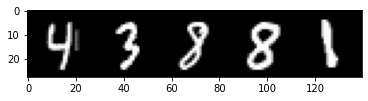

In [16]:
plt.imshow(images, cmap='gray')

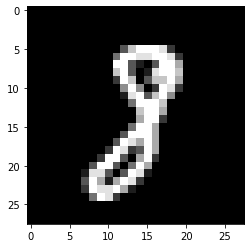

In [19]:
# Checking out the images
try:
    i += 1
except:
    i = 0

plt.imshow(train_dataset.data[i], cmap="gray")

In [210]:
test_results_df.groupby(['Correct', 'Similarity']).count()

Prediction  Ground Truth
Correct Similarity                          
False   0.0                399           399
        0.4                  7             7
        0.6                 76            76
        0.8                490           490
        1.0                  5             5
True    1.0               1023          1023

In [262]:
test_results_df[
    (test_results_df["Similarity"] == 0.0) & (test_results_df["Prediction"] != "")
]

,Correct,Similarity,Prediction,Ground Truth


All similarity 0 results were sequences for which there was no prediction. If a prediction was made it is likely to be very similar (4/5 letters or 0.8 similarity) 490/573 = 86%

Interesting edge case, spaces sometimes detected:

In [211]:
test_results_df[(test_results_df['Correct'] == False) & (test_results_df['Similarity'] == 1.0)]

,Correct,Similarity,Prediction,Ground Truth
1299,False,1.0,40 950,40950
1765,False,1.0,82 430,82430
1834,False,1.0,08 416,08416
1967,False,1.0,19844,19484
1980,False,1.0,81 789,81789


In [257]:
accuracy = sum(test_results_df['Correct'] == True) / len(test_results_df)
print(f'Complete Match Accuracy: {accuracy*100:.1f}%')
avg_sim = test_results_df['Similarity'].mean()
print(f'Mean Similarity Measure: {avg_sim:.2f}')

Complete Match Accuracy: 51.1%
Mean Similarity Measure: 0.73
